#  Imports


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Activation, Dropout, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Precision, Recall, AUC
from tensorflow.keras.applications import Xception, EfficientNetB0
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, accuracy_score

from sklearn.metrics import f1_score


import seaborn as sns
import matplotlib.pyplot as plt
import os

# Function Definitions

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def train_val_generators_shear(train_dir, val_dir):
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode='nearest'
    )

    val_datagen = ImageDataGenerator(rescale=1./255.)

    train_generator = train_datagen.flow_from_directory(
        directory=train_dir,
        target_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        class_mode='categorical'
    )

    val_generator = val_datagen.flow_from_directory(
        directory=val_dir,
        target_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        class_mode='categorical'
    )

    return train_generator, val_generator


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

import seaborn as sns
import matplotlib.pyplot as plt

def plot_training_history(history):
    # Plotear el historial de entrenamiento
    eps = range(len(history.history["loss"]))
    plt.figure(figsize=(10, 6))
    plt.plot(eps, history.history["loss"])
    plt.plot(eps, history.history["val_loss"])
    plt.legend(["loss", "val_loss"])
    plt.title('Training History - Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.show()

    # Plotear la precisión
    plt.figure(figsize=(10, 6))
    plt.plot(eps, history.history["accuracy"])
    plt.plot(eps, history.history["val_accuracy"])
    plt.legend(["accuracy", "val_accuracy"])
    plt.title('Training History - Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.show()

def check_precision(model, test_generator):
    # Asignar e imprimir etiquetas
    test_labels, pred_labels = assign_labels(test_generator, model, print_info=False)

    # Imprimir la matriz de confusión y la precisión
    cm = confusion_matrix(test_labels, pred_labels)
    accuracy = accuracy_score(test_labels, pred_labels)

    print("Matriz de Confusión:")
    print(cm)
    print("Precisión:", accuracy)
    return cm





In [ ]:
def plot_confusion_matrix(cm, classes):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.title('Matriz de Confusión')
    plt.xlabel('Etiquetas Predichas')
    plt.ylabel('Etiquetas Verdaderas')
    plt.show()

# Configuracion inicial

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:

# Directorio base después de montar el drive
base_path = '/content/drive/My Drive/DataSet'

# Listar archivos en el directorio base
files = os.listdir(base_path)

path_root = '/content/drive/My Drive/DataSet'

valid_dir = os.path.join(path_root, 'val')
train_dir = os.path.join(path_root, 'train')
test_dir = os.path.join(path_root, 'test')

In [ ]:
bc_types = [file for file in os.listdir(train_dir) if os.path.isdir(os.path.join(train_dir, file))]
print("Types: ", bc_types)

# to encode labels
bc_dict = {'InSitu': 3, 'Benign': 2, 'Normal': 1, 'Invasive': 4}
print("Encode: ", bc_dict)

# to decode labels
dict_bc = {1: "Normal", 2: "Benign", 3: "InSitu", 4: "Invasive"}
print("Decode: ", dict_bc)

classes = [dict_bc[i] for i in sorted(dict_bc.keys())]


Types:  ['InSitu', 'Normal', 'Invasive', 'Benign']
Encode:  {'InSitu': 3, 'Benign': 2, 'Normal': 1, 'Invasive': 4}
Decode:  {1: 'Normal', 2: 'Benign', 3: 'InSitu', 4: 'Invasive'}


In [ ]:
# Set IMG_SIZE and BATCH_SIZE
IMG_SIZE = (512, 512)
BATCH_SIZE = 8
NUM_CLASES = 4


In [ ]:
train_generator_2, val_generator_2 = train_val_generators_shear(train_dir, valid_dir)   # create image generators to feed images to the model


Found 319 images belonging to 4 classes.
Found 81 images belonging to 4 classes.


# Create models

In [ ]:
#Para poder incluir el valor f1 en el entrenamiento del modelo creamos las siguientes
#funciones para añadirlo como una función siguiendo la referencia del sigueinte enlace
#https://datascience.stackexchange.com/questions/45165/how-to-get-accuracy-f1-precision-and-recall-for-a-keras-model

from keras import backend as K
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))



## ENTRENAMIENTO DE MODELOS

In [ ]:
from tensorflow.keras import layers, models
from tensorflow.keras.applications import Xception, EfficientNetB0, InceptionV3, VGG16, VGG19, ResNet50
from tensorflow.keras.optimizers import Adam
import tensorflow as tf


In [ ]:
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers, models

def build_model_with_base(base_model, num_classes, img_size1, img_size2, learning_rate, freeze_layers=None, additional_layers=None):
    inputs = layers.Input(shape=(img_size1, img_size2, 3))

    # Configurar el modelo base
    base_model = base_model(include_top=False, input_tensor=inputs, weights="imagenet")

    # Congelar todas las capas si freeze_layers es None
    if freeze_layers == 'all':
        for layer in base_model.layers:
            layer.trainable = False
    elif isinstance(freeze_layers, int):
        # Congelar las primeras 'freeze_layers' capas
        for layer in base_model.layers[:freeze_layers]:
            layer.trainable = False
    else:
        raise ValueError("El argumento freeze_layers debe ser 'all' o un entero.")

    # Construir el modelo con el modelo base
    x = base_model.output

    # Agregar capas adicionales si se proporcionan
    if additional_layers:
        for layer in additional_layers:
            x = layer(x)

    # Agregar capas de convolución adicionales
    x = layers.Conv2D(64, (3, 3), activation="relu", padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D(2, 2)(x)

    x = layers.Conv2D(128, (3, 3), activation="relu", padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D(2, 2)(x)

    # Agregar capas finales
    x = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D(2, 2)(x)

    # Agregar GlobalAveragePooling2D
    x = GlobalAveragePooling2D()(x)

    x = layers.Dropout(0.3)(x)
    x = Dense(64, activation="relu")(x)
    outputs = Dense(num_classes, activation="softmax")(x)

    # Compilar el modelo
    model = models.Model(inputs, outputs, name=f"CustomModel_{base_model.name}")
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=['acc', f1_m, precision_m, recall_m])

    return model


In [ ]:
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers, models

def build_model_with_base_v2(base_model, num_classes, img_size1, img_size2, learning_rate, freeze_layers=None, additional_layers=None):
    inputs = layers.Input(shape=(img_size1, img_size2, 3))
    base_model = base_model(include_top=False, input_tensor=inputs, weights="imagenet")

    # Congelar todas las capas si freeze_layers es None
    if freeze_layers == 'all':
        for layer in base_model.layers:
            layer.trainable = False
    elif isinstance(freeze_layers, int):
        # Congelar las primeras 'freeze_layers' capas
        for layer in base_model.layers[:freeze_layers]:
            layer.trainable = False
    else:
        raise ValueError("El argumento freeze_layers debe ser 'all' o un entero.")

    # Construir el modelo con el modelo base

    x = base_model.output

    # Reducir el número de capas de convolución
    x = layers.Conv2D(64, (3, 3), activation="relu", padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D(2, 2)(x)

    # Agregar una capa de convolución adicional
    x = layers.Conv2D(128, (3, 3), activation="relu", padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D(2, 2)(x)

    # Agregar GlobalAveragePooling2D
    x = layers.GlobalAveragePooling2D()(x)

    x = layers.Dropout(0.3)(x)
    x = layers.Dense(64, activation="relu")(x)
    outputs = layers.Dense(num_classes, activation="softmax")(x)

    # Compilar el modelo
    model = models.Model(inputs, outputs, name=f"CustomModel_{base_model.name}")
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=['accuracy'])

    return model


In [ ]:
xception_model_final_1 = build_model_with_base(Xception, NUM_CLASES, IMG_SIZE[0], IMG_SIZE[1],0.00005,0)


83683744/83683744 [==============================] - 5s 0us/step


In [ ]:
xception_model_final_2 = build_model_with_base_v2(Xception, NUM_CLASES, IMG_SIZE[0], IMG_SIZE[1],0.00005,0)


# Entrenamiento de modelos

In [ ]:
# Specify the directory to save the models
save_dir = '/content/drive/My Drive/SavedModels'

# Ensure the directory exists, create it if necessary
os.makedirs(save_dir, exist_ok=True)

In [ ]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)   # limitation to stop somewhere early


In [ ]:
print("\n[INFO] Ready to train. Training is starting!\n")
BATCH_SIZE = 8



[INFO] Ready to train. Training is starting!



In [ ]:
#xception_model_final_3 = build_model_with_base(Xception, NUM_CLASES, IMG_SIZE[0], IMG_SIZE[1],0.00005,0)

#hist_xception_final_3 = xception_model_final_3.fit(train_generator_2, validation_data=val_generator_2, epochs=50)
xception_model = build_model_with_base_v2(Xception, NUM_CLASES, IMG_SIZE[0], IMG_SIZE[1], 0.00005, 0)


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.models import clone_model

# Función para definir el cambio de la tasa de aprendizaje durante el entrenamiento
def lr_scheduler(epoch, lr):
    return lr * np.exp(-0.1)

# Rango de tasas de aprendizaje a probar
lr_values = [1e-6, 5e-6, 1e-5, 5e-5, 1e-4, 5e-4, 1e-3]

# Lista para almacenar la pérdida final de cada tasa de aprendizaje
final_losses = []

# Entrenar el modelo con diferentes tasas de aprendizaje
for lr_value in lr_values:
    # Clonar el modelo original para evitar afectar el modelo principal
    current_model = clone_model(xception_model)

    # Compilar el modelo con la tasa de aprendizaje actual
    current_model.compile(optimizer=Adam(learning_rate=lr_value),
                          loss="categorical_crossentropy",
                          metrics=['accuracy', f1_m, precision_m, recall_m])

    # Configurar el planificador de tasa de aprendizaje
    lr_schedule = LearningRateScheduler(lr_scheduler, verbose=1)

    # Entrenar el modelo
    current_model.fit(train_generator_2, validation_data=val_generator_2, epochs=20, verbose=0, callbacks=[lr_schedule])

    # Calcular la pérdida final en el conjunto de validación
    final_loss = current_model.evaluate(val_generator_2)[0]

    # Almacenar la pérdida final
    final_losses.append(final_loss)



Epoch 1: LearningRateScheduler setting learning rate to 9.048374157514646e-07.

Epoch 2: LearningRateScheduler setting learning rate to 8.187307428921048e-07.

Epoch 3: LearningRateScheduler setting learning rate to 7.408182346495259e-07.

Epoch 4: LearningRateScheduler setting learning rate to 6.703200479219312e-07.

Epoch 5: LearningRateScheduler setting learning rate to 6.065306618131762e-07.

Epoch 6: LearningRateScheduler setting learning rate to 5.488116254313863e-07.

Epoch 7: LearningRateScheduler setting learning rate to 4.965852829345698e-07.

Epoch 8: LearningRateScheduler setting learning rate to 4.493289614827018e-07.

Epoch 9: LearningRateScheduler setting learning rate to 4.0656964781330553e-07.

Epoch 10: LearningRateScheduler setting learning rate to 3.678794363278189e-07.

Epoch 11: LearningRateScheduler setting learning rate to 3.3287108004606614e-07.

Epoch 12: LearningRateScheduler setting learning rate to 3.011942102034093e-07.

Epoch 13: LearningRateScheduler se

Se itera sobre cada valor de tasa de aprendizaje. Por cada valor, se clona el modelo original para evitar afectar el modelo principal, se compila con la tasa de aprendizaje actual, se entrena durante 30 épocas y se evalúa la pérdida final en el conjunto de validación. La pérdida final se agrega a la lista final_losses.

En resumen, este código realiza una búsqueda de la mejor tasa de aprendizaje entre las tasas especificadas, y almacena las pérdidas finales correspondientes para su análisis y selección del mejor valor de tasa de aprendizaje.

La mejor tasa de aprendizaje es: 5e-05


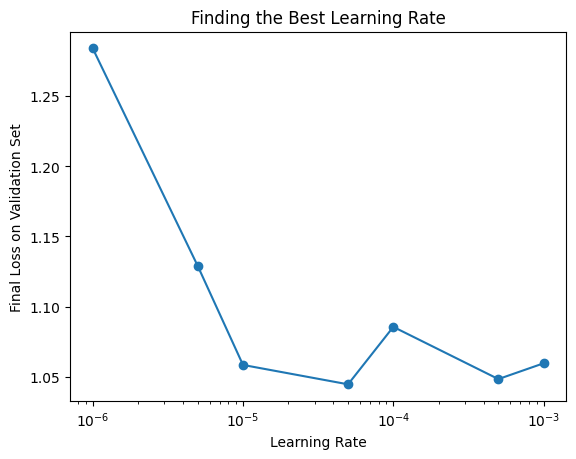

In [ ]:

# Entrenar el modelo con tasas de aprendizaje crecientes
# Encontrar la tasa de aprendizaje con la menor pérdida final
best_lr_index = np.argmin(final_losses)
best_lr = lr_values[best_lr_index]

print("La mejor tasa de aprendizaje es:", best_lr)

# Graficar la pérdida final en función de las tasas de aprendizaje
plt.plot(lr_values, final_losses, marker='o')
plt.xscale('log')
plt.xlabel('Learning Rate')
plt.ylabel('Final Loss on Validation Set')
plt.title('Finding the Best Learning Rate')
plt.show()

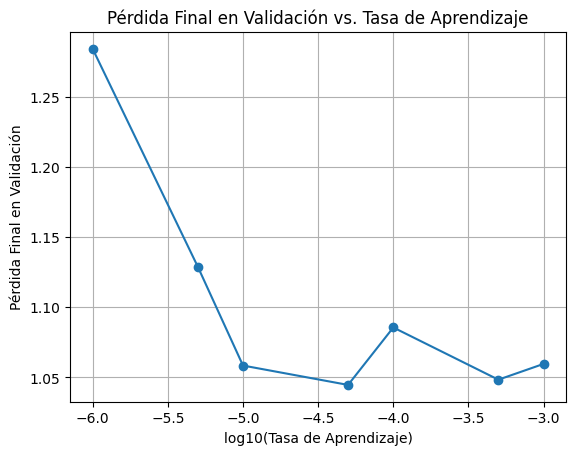

Resultados de la búsqueda de tasa de aprendizaje:
Tasa de Aprendizaje: 1e-06, Pérdida Final en Validación: 1.2839945554733276
Tasa de Aprendizaje: 5e-06, Pérdida Final en Validación: 1.128906488418579
Tasa de Aprendizaje: 1e-05, Pérdida Final en Validación: 1.058424711227417
Tasa de Aprendizaje: 5e-05, Pérdida Final en Validación: 1.0446182489395142
Tasa de Aprendizaje: 0.0001, Pérdida Final en Validación: 1.0855433940887451
Tasa de Aprendizaje: 0.0005, Pérdida Final en Validación: 1.0483511686325073
Tasa de Aprendizaje: 0.001, Pérdida Final en Validación: 1.059599757194519
La mejor tasa de aprendizaje es: 5e-05


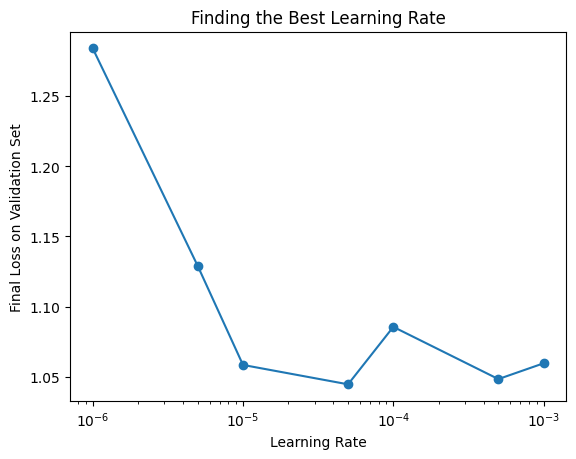

In [ ]:
import matplotlib.pyplot as plt

# Graficar los resultados
plt.plot(np.log10(lr_values), final_losses, marker='o')
plt.title('Pérdida Final en Validación vs. Tasa de Aprendizaje')
plt.xlabel('log10(Tasa de Aprendizaje)')
plt.ylabel('Pérdida Final en Validación')
plt.grid(True)
plt.show()

# Encontrar la mejor tasa de aprendizaje
best_lr_index = np.argmin(final_losses)
best_lr = lr_values[best_lr_index]

print("Resultados de la búsqueda de tasa de aprendizaje:")
for lr, loss in zip(lr_values, final_losses):
    print(f"Tasa de Aprendizaje: {lr}, Pérdida Final en Validación: {loss}")

print("La mejor tasa de aprendizaje es:", best_lr)

# Graficar la pérdida final en función de las tasas de aprendizaje
plt.plot(lr_values, final_losses, marker='o')
plt.xscale('log')
plt.xlabel('Learning Rate')
plt.ylabel('Final Loss on Validation Set')
plt.title('Finding the Best Learning Rate')
plt.show()

In [ ]:
import pandas as pd

# Definir los datos
data = {
    'Tasa de Aprendizaje': [1e-06, 5e-06, 1e-05, 5e-05, 0.0001, 0.0005, 0.001],
    'Pérdida Final en Validación': [1.2839945554733276, 1.128906488418579, 1.058424711227417, 1.0446182489395142, 1.0855433940887451, 1.0483511686325073, 1.059599757194519]
}

# Crear un DataFrame
df = pd.DataFrame(data)

# Mostrar la tabla
df.style.hide_index()


<ipython-input-1-a59d84eaf87d>:13: FutureWarning: this method is deprecated in favour of `Styler.hide(axis="index")`
  df.style.hide_index()


Tasa de Aprendizaje,Pérdida Final en Validación
0.000001,1.283995
0.000005,1.128906
0.000010,1.058425
0.000050,1.044618
0.000100,1.085543
0.000500,1.048351
0.001000,1.059600


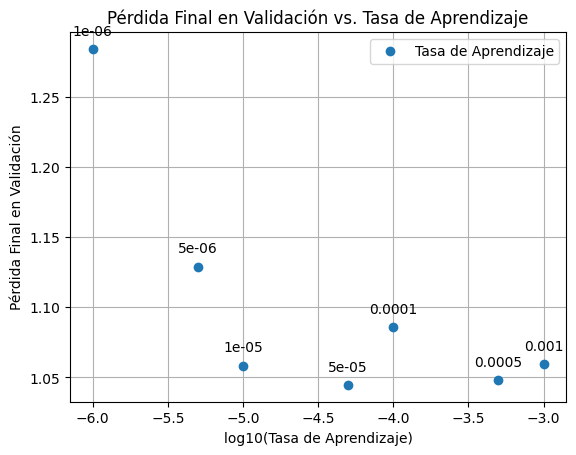

Resultados de la búsqueda de tasa de aprendizaje:
Tasa de Aprendizaje: 1e-06, Pérdida Final en Validación: 1.2839945554733276
Tasa de Aprendizaje: 5e-06, Pérdida Final en Validación: 1.128906488418579
Tasa de Aprendizaje: 1e-05, Pérdida Final en Validación: 1.058424711227417
Tasa de Aprendizaje: 5e-05, Pérdida Final en Validación: 1.0446182489395142
Tasa de Aprendizaje: 0.0001, Pérdida Final en Validación: 1.0855433940887451
Tasa de Aprendizaje: 0.0005, Pérdida Final en Validación: 1.0483511686325073
Tasa de Aprendizaje: 0.001, Pérdida Final en Validación: 1.059599757194519
La mejor tasa de aprendizaje es: 5e-05


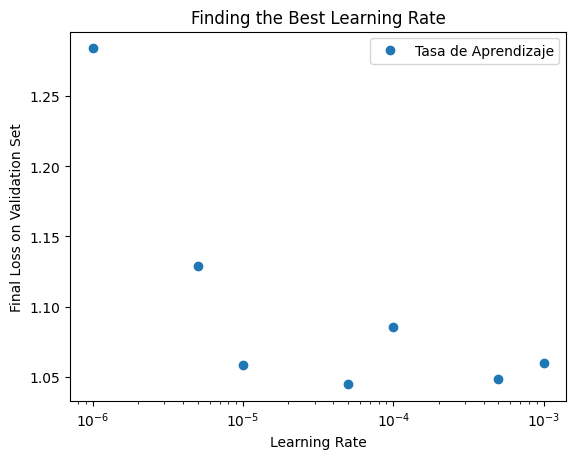

In [ ]:
import matplotlib.pyplot as plt

# Graficar los resultados con etiquetas de tasa de aprendizaje
plt.plot(np.log10(lr_values), final_losses, marker='o', linestyle='', label='Tasa de Aprendizaje')
plt.title('Pérdida Final en Validación vs. Tasa de Aprendizaje')
plt.xlabel('log10(Tasa de Aprendizaje)')
plt.ylabel('Pérdida Final en Validación')
plt.grid(True)
plt.legend()

# Etiquetar cada punto con el valor de la tasa de aprendizaje
for i, txt in enumerate(lr_values):
    plt.annotate(f'{txt}', (np.log10(lr_values[i]), final_losses[i]), textcoords="offset points", xytext=(0,10), ha='center')

plt.show()

# Encontrar la mejor tasa de aprendizaje
best_lr_index = np.argmin(final_losses)
best_lr = lr_values[best_lr_index]

print("Resultados de la búsqueda de tasa de aprendizaje:")
for lr, loss in zip(lr_values, final_losses):
    print(f"Tasa de Aprendizaje: {lr}, Pérdida Final en Validación: {loss}")

print("La mejor tasa de aprendizaje es:", best_lr)

# Graficar la pérdida final en función de las tasas de aprendizaje
plt.plot(lr_values, final_losses, marker='o', linestyle='', label='Tasa de Aprendizaje')
plt.xscale('log')
plt.xlabel('Learning Rate')
plt.ylabel('Final Loss on Validation Set')
plt.title('Finding the Best Learning Rate')
plt.legend()
plt.show()


In [ ]:
import itertools

# Definir diferentes valores para batch size y epochs a probar
batch_sizes = [4, 8, 16, 32]
epochs_values = [10, 20, 25, 30, 35]

best_loss = float('inf')
best_batch_size = None
best_epochs = None

# Iterar sobre todas las combinaciones de batch size y epochs
for batch_size, epochs in itertools.product(batch_sizes, epochs_values):
    try:
        # Crear y compilar el modelo con los valores actuales
        current_model = build_model_with_base_v2(Xception, NUM_CLASES, IMG_SIZE[0], IMG_SIZE[1], 0.00005, 0)

        # Entrenar el modelo con los valores actuales
        history = current_model.fit(train_generator_2, validation_data=val_generator_2,
                                    epochs=epochs, batch_size=batch_size, verbose=0, callbacks=[lr_schedule])


        # Obtener la pérdida final en el conjunto de validación
        final_loss = current_model.evaluate(val_generator_2)[0]

        # Actualizar el mejor conjunto de hiperparámetros si es necesario
        if final_loss < best_loss:
            best_loss = final_loss
            best_batch_size = batch_size
            best_epochs = epochs

    except Exception as e:
        print(f"Error durante el entrenamiento con batch_size={batch_size} y epochs={epochs}: {e}")

# Imprimir los mejores hiperparámetros encontrados
print("Mejor Batch Size:", best_batch_size)
print("Mejor Número de Épocas:", best_epochs)
print("Mejor Pérdida Final en Validación:", best_loss)



Epoch 1: LearningRateScheduler setting learning rate to 4.524186975889218e-05.

Epoch 2: LearningRateScheduler setting learning rate to 4.0936535087243146e-05.

Epoch 3: LearningRateScheduler setting learning rate to 3.704090844069694e-05.

Epoch 4: LearningRateScheduler setting learning rate to 3.351599869284479e-05.

Epoch 5: LearningRateScheduler setting learning rate to 3.0326531136164822e-05.

Epoch 6: LearningRateScheduler setting learning rate to 2.7440580448624476e-05.

Epoch 7: LearningRateScheduler setting learning rate to 2.482926455820091e-05.

Epoch 8: LearningRateScheduler setting learning rate to 2.2466448382739403e-05.

Epoch 9: LearningRateScheduler setting learning rate to 2.032848377938469e-05.

Epoch 10: LearningRateScheduler setting learning rate to 1.839397253646768e-05.
11/11 [==============================] - 3s 229ms/step - loss: 0.6148 - accuracy: 0.7284

Epoch 1: LearningRateScheduler setting learning rate to 4.524186975889218e-05.

Epoch 2: LearningRateSche

In [ ]:
plt.figure(figsize=(12, 8))
for result in results:
    batch_size, epochs, final_loss = result
    label = f"Batch Size: {batch_size}, Epochs: {epochs}"
    plt.plot(history.history['val_loss'], label=label)

plt.title('Pérdida en Validación a lo Largo del Tiempo para Diferentes Combinaciones de Batch Size y Epochs')
plt.xlabel('Épocas')
plt.ylabel('Pérdida en Validación')
plt.legend()
plt.grid(True)
plt.show()


NameError: ignored

<Figure size 1200x800 with 0 Axes>

# Evaluacion de modelos

# validacion de resultados

In [ ]:
from tensorflow.keras.models import load_model
import os

save_dir = '/content/drive/My Drive/SavedModels'


xception_model_generator_2.save(os.path.join(save_dir, 'final_xception_model_v5.h5'))